In [1]:
import torch
from dataset import read_data
from genechat_model import GeneChatModel

device = "cuda" if torch.cuda.is_available() else "cpu"

train_data, test_data, _, _ = read_data()

model = GeneChatModel(
    gene_chunk_nt=512,
    gene_chunk_overlap=0,
    freeze_gene_encoder=True,
).to(device)

state = torch.load("genechat_checkpoints/model_best.pt", map_location=device)
model.load_state_dict(state)

example1 = test_data[10]
example2 = test_data[200]

for ex_i, ex in enumerate([example1, example2], start=1):
    dna = ex["dna"]
    target = ex["target"]
    print(f"\n=== Example {ex_i} Ground Truth ===")
    print(target)

    gen = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.8,
        top_k=50,
    )
    print(f"\n=== Example {ex_i} Model Output ===")
    print(gen)


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/tmp/ipykernel_111/992382303.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=


=== Example 1 Ground Truth ===
This genomic region was validated as an active enhancer by the ChIP-STARR-seq massively parallel reporter assay in naive human embryonic stem cells. This enhancer is marked by the H3K27ac and H3K4me1 histone modifications.

=== Example 1 Model Output ===
brane protein 175). Predicted to be active in plasma membrane. Orthologous to human TMEM175C (transmembrane protein 175C). Orthologous to human TMEM175E (transmembrane protein 175E). Orthologous to human TMEM175F (trans

=== Example 2 Ground Truth ===
This genomic sequence was predicted to be a transcriptional regulatory region based on chromatin state analysis from the ENCODE (ENCyclopedia Of DNA Elements) project. It was validated as a functional repressive element by the Sharpr-MPRA technique (Systematic high-resolution activation and repression profiling with reporter tiling using massively parallel reporter assays) in K562 erythroleukemia cells (group: K562 Repressive DNase unmatched - State 12:Ctcf

In [4]:
# model.eval()

In [8]:
import random, numpy as np
from sacrebleu import BLEU
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Metrics
bleu = BLEU(effective_order=True)  
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_metrics(ref, pred):
    """Compute BLEU, METEOR, ROUGE-L for a single pair."""
    # BLEU
    bleu_score = bleu.sentence_score(pred, [ref]).score

    # METEOR
    ref_tok = ref.split()
    pred_tok = pred.split()
    meteor = meteor_score([ref_tok], pred_tok)

    # ROUGE-L
    rouge_l = rouge.score(ref, pred)["rougeL"].fmeasure

    return {
        "bleu": bleu_score,
        "meteor": meteor,
        "rougeL": rouge_l,
    }


In [9]:
import nltk
nltk.download('wordnet', download_dir='/home/jovyan/nltk_data')
nltk.data.path.append('/home/jovyan/nltk_data')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
NUM_SAMPLES = 20
random_indices = random.sample(range(len(test_data)), NUM_SAMPLES)
metrics_list = []

for idx in random_indices:
    ex = test_data[idx]
    dna = ex["dna"]
    ref = ex["target"]

    pred = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.7,
        top_k=50,
    )

    m = compute_metrics(ref, pred)
    metrics_list.append(m)

    print(f"\n--- Sample idx {idx} ---")
    print("Ground Truth:", ref[:200].replace("\n"," ") + "...")
    print("Prediction:  ", pred[:200].replace("\n"," ") + "...")
    print("Metrics:", m)

# ---------- Aggregate ----------
avg_bleu   = np.mean([m["bleu"] for m in metrics_list])
avg_meteor = np.mean([m["meteor"] for m in metrics_list])
avg_rouge  = np.mean([m["rougeL"] for m in metrics_list])


--- Sample idx 795 ---
Ground Truth: Killer cell immunoglobulin-like receptors (KIRs) are transmembrane glycoproteins expressed by natural killer cells and subsets of T cells. The KIR genes are polymorphic and highly homologous and they ...
Prediction:   be located in cytosol; nucleoplasm; and plasma membrane. Predicted to be active in axonemal dynein complex and cytoplasm. Orthologous to human DYNC1 (dynein complex component 1). Orthologous to human ...
Metrics: {'bleu': 0.005911793076463709, 'meteor': 0.023020257826887665, 'rougeL': 0.051470588235294115}

--- Sample idx 1318 ---
Ground Truth: KRT12 encodes the type I intermediate filament chain keratin 12, expressed in corneal epithelia. Mutations in this gene lead to Meesmann corneal dystrophy....
Prediction:   positive regulation of signal transduction; and regulation of mitotic spindle assembly. Located in cytoplasm and nucleus. Orthologous to human MAP2K14 (mitogen-activated protein kinase kinase 14). Ort...
Metrics: {'bleu': 1.

In [28]:
bleu_scores = []
chrf_scores = []
rouge_scores = []

for ex in tqdm(test_data):
    dna = ex["dna"]
    ref = ex["target"]

    pred = model.generate(
        dna=dna,
        max_new_tokens=80,
        device=device,
        temperature=0.7,
        top_k=50,
    )

    m = compute_metrics(ref, pred)
    bleu_scores.append(m["bleu"])
    chrf_scores.append(m["meteor"])
    rouge_scores.append(m["rougeL"])



100%|██████████| 4106/4106 [44:54<00:00,  1.52it/s]



===== AVERAGE METRICS =====
BLEU:    3.9188
chrF:    0.1128
ROUGE-L: 0.1442


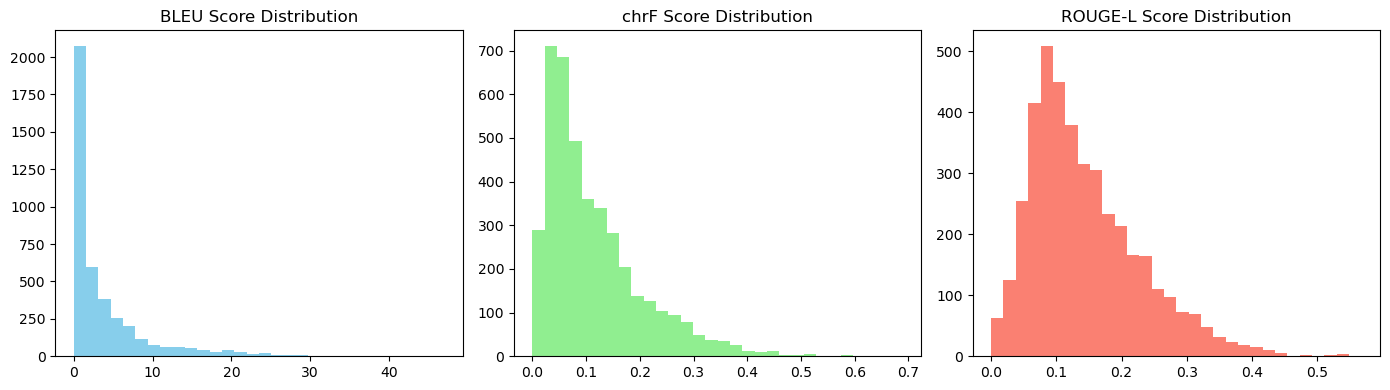

/tmp/ipykernel_111/585757439.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bleu_scores, chrf_scores, rouge_scores], labels=['BLEU','chrF','ROUGE-L'])


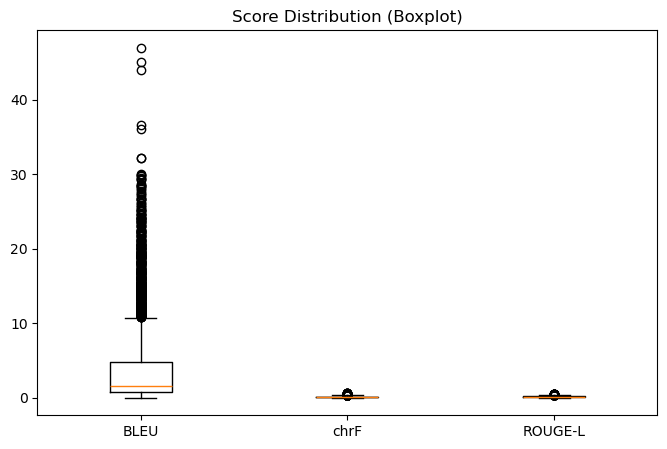

In [29]:
avg_bleu = np.mean(bleu_scores)
avg_chrf = np.mean(chrf_scores)
avg_rouge = np.mean(rouge_scores)

print("\n===== AVERAGE METRICS =====")
print(f"BLEU:    {avg_bleu:.4f}")
print(f"chrF:    {avg_chrf:.4f}")
print(f"ROUGE-L: {avg_rouge:.4f}")


plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.hist(bleu_scores, bins=30, color='skyblue')
plt.title("BLEU Score Distribution")

plt.subplot(1,3,2)
plt.hist(chrf_scores, bins=30, color='lightgreen')
plt.title("chrF Score Distribution")

plt.subplot(1,3,3)
plt.hist(rouge_scores, bins=30, color='salmon')
plt.title("ROUGE-L Score Distribution")

plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(8,5))
plt.boxplot([bleu_scores, chrf_scores, rouge_scores], labels=['BLEU','chrF','ROUGE-L'])
plt.title("Score Distribution (Boxplot)")
plt.show()